### Comparing ML modelling with hierarchical time-series methods (top-down and bottom-up approach) for the Walmart M5 dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore")

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# cal_features includes the features engineered for the ML model.
# sales includes all of the item sales information
sales = pd.read_csv(
    "/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv"
)
cal_feature = pd.read_csv(
    "/Users/user/hts-forecast/volume/data/processed/sales_cal_features.csv"
)
cal_features = cal_feature.drop("Unnamed: 0", axis="columns")

<IPython.core.display.Javascript object>

##### The date-dependant features for the ML model are:
wday = working day (1-7), where 1=Saturday and 7=Friday

month = month of the year (1-12)

event_type_1 = if there is an event (e.g. festive or national event), event_type_1 = 1

week_of_year = the week of the year (1-52) 

We also use exponential time smoothing of the target feature (sales) as an input feature. This is done later in the code. 

In [3]:
cal_features.head()

,date,wday,month,event_type_1,week_of_year
0,2011-01-29,1,1,0,4
1,2011-01-30,2,1,0,4
2,2011-01-31,3,1,0,5
3,2011-02-01,4,2,0,5
4,2011-02-02,5,2,0,5


<IPython.core.display.Javascript object>

#### Functions used in the analysis:

In [4]:
# Symmetric mean absolute error used to find error between Actual (A) and Forecast (F) values
def smape(A: pd.Series, F: pd.Series):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

<IPython.core.display.Javascript object>

In [5]:
# take the dataframe and only present the relevant category
def filter_aggregate_sales(
    frame: pd.DataFrame,
    column_to_filter: str,
    column_value_to_filter: str,
    column_to_aggregate: str,
):
    frame = frame[frame[column_to_filter] == column_value_to_filter]
    frame = frame.groupby(column_to_aggregate).sum().T
    return frame

<IPython.core.display.Javascript object>

In [6]:
# ETSmodel prediction (input feature)
def ETS_predict(
    frame: pd.DataFrame, column_to_predict: pd.DataFrame, days_to_predict: pd.DataFrame
):
    modelETS = ETSModel(
        frame.set_index("date")[column_to_predict].iloc[:-days_to_predict] / 100,
        error="add",
        trend="add",
        seasonal="add",
        damped_trend=False,
        seasonal_periods=7,
    )
    fit = modelETS.fit()
    prediction = fit.predict(start=frame.date.min(), end=frame.date.max())
    frame = frame.assign(ETS=prediction.values * 100).set_index("date")
    return frame

<IPython.core.display.Javascript object>

In [7]:
# Create training/test dataset
def train_test_set(
    frame: pd.DataFrame, target_feature: str, start_date: str, end_date: str
):
    splittedframe = frame[start_date:end_date]
    input_train = splittedframe.drop(target_feature, axis="columns")
    target_train = splittedframe[target_feature]
    return input_train, target_train

<IPython.core.display.Javascript object>

In [8]:
# Model and predict data using Random Forest
def forest(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted

<IPython.core.display.Javascript object>

In [9]:
# Function to create train/test split and do model and prediction
def split_n_model(
    frame: pd.DataFrame,
    target_feature: str,
    train_start_date: str,
    train_end_date: str,
    test_start_date: str,
    test_end_date: str,
):

    X_train, y_train = train_test_set(
        frame=frame,
        target_feature=target_feature,
        start_date=train_start_date,
        end_date=train_end_date,
    )

    X_test, y_test = train_test_set(
        frame=frame,
        target_feature=target_feature,
        start_date=test_start_date,
        end_date=test_end_date,
    )

    y_predicted = forest(X_train, y_train, X_test)

    return y_test, y_predicted

<IPython.core.display.Javascript object>

#### Functions for top-down HTS:

In [10]:
# Takes the top of hierarchical chain (e.g. FOODS) and outputs the actual
# -sales per day and the predicted sales (for testing in top-down HTS)


def top_of_hierarchy(column_to_filter: str, column_value_to_filter: str):
    featureframe = cal_features.copy()
    featureframe.date = pd.to_datetime(featureframe.date)

    featureframe[column_value_to_filter] = filter_aggregate_sales(
        frame=sales,
        column_to_filter=column_to_filter,
        column_value_to_filter=column_value_to_filter,
        column_to_aggregate=column_to_filter,
    )[column_value_to_filter].values

    featureframe["ETS"] = ETS_predict(
        frame=featureframe,
        column_to_predict=column_value_to_filter,
        days_to_predict=120,
    )["ETS"].values

    featureframe.set_index("date", inplace=True)

    featureframe_y_test, featureframe_y_predicted = split_n_model(
        frame=featureframe,
        target_feature=column_value_to_filter,
        train_start_date="2011-01-29",
        train_end_date="2016-01-22",
        test_start_date="2016-01-24",
        test_end_date="2016-05-22",
    )

    top_of_chain_sales = featureframe[column_value_to_filter].values
    prediction_for_top_of_chain_sales = featureframe_y_predicted

    return top_of_chain_sales, prediction_for_top_of_chain_sales

<IPython.core.display.Javascript object>

In [11]:
# Takes the sub category and returns the ratio of RMSE between top-down and direct random forest, where
# ratio < 1 means top-down outperforms direct random forest, and vice versa
def topdown_compare_ratio(
    column_to_filter: str,
    column_value_to_filter: str,
    top_of_chain_sales: pd.Series,
    prediction_for_top_of_chain_sales: pd.Series,
):
    featureframe = cal_features.copy()
    featureframe.date = pd.to_datetime(featureframe.date)

    featureframe[column_value_to_filter] = filter_aggregate_sales(
        frame=sales,
        column_to_filter=column_to_filter,
        column_value_to_filter=column_value_to_filter,
        column_to_aggregate=column_to_filter,
    )[column_value_to_filter].values

    featureframe["ETS"] = ETS_predict(
        frame=featureframe,
        column_to_predict=column_value_to_filter,
        days_to_predict=120,
    )["ETS"].values

    featureframe.set_index("date", inplace=True)

    featureframe_y_test, featureframe_y_predicted = split_n_model(
        frame=featureframe,
        target_feature=column_value_to_filter,
        train_start_date="2011-01-29",
        train_end_date="2016-01-22",
        test_start_date="2016-01-24",
        test_end_date="2016-05-22",
    )

    # rmse_direct = sqrt(mean_squared_error(featureframe_y_test, featureframe_y_predicted))
    sales_fraction = (
        featureframe[column_value_to_filter][:-120].sum()
        / top_of_chain_sales[:-120].sum()
    )
    # rmse_topdown = sqrt(mean_squared_error(featureframe_y_test, prediction_for_top_of_chain_sales*(sales_fraction)))
    # RMSE_ratio = rmse_topdown/rmse_direct
    # If RMSE_ratio < 1, then top_down HTS out-performs direct random forest modelling
    smape_direct = smape(featureframe_y_test, featureframe_y_predicted)
    smape_topdown = smape(
        featureframe_y_test, prediction_for_top_of_chain_sales * (sales_fraction)
    )
    smape_ratio = smape_topdown / smape_direct
    # If smape_ratio < 1, then top_down HTS out-performs direct random forest modelling

    return smape_ratio

<IPython.core.display.Javascript object>

#### Functions for bottom-up HTS:

In [12]:
#Create two dataframes: All individual 216 (grouped) FOODS_1 items 1)test and 2)predicted data for last 120 days 
# Note: these are Level 3 predictions 
def level_3_prediction(items_sub_category: str):
    sub_cat_sales = sales[sales.dept_id==items_sub_category].groupby('item_id').sum().T
    sub_cat_sales = sub_cat_sales.reset_index().drop('index', axis='columns')
    sub_cat_120days_real = pd.DataFrame()
    sub_cat_120days_predicted = pd.DataFrame()

    featureframe = pd.DataFrame()
    for col in sub_cat_sales:
        featureframe = cal_features.copy()
        featureframe.date = pd.to_datetime(featureframe.date)
        
        featureframe[col] = sub_cat_sales[col].values
        
        featureframe['ETS'] = ETS_predict(frame=featureframe, column_to_predict=col, 
                                          days_to_predict=120)['ETS'].values
        
        featureframe.set_index('date', inplace=True)
        
        featureframe_y_test, featureframe_y_predicted = split_n_model(
            frame=featureframe, 
            target_feature=col,
            train_start_date='2011-01-29', 
            train_end_date='2016-01-22', 
            test_start_date='2016-01-24', 
            test_end_date='2016-05-22'
        )
        
        sub_cat_120days_real[col] = featureframe_y_test.values
        sub_cat_120days_predicted[col] = featureframe_y_predicted
    return sub_cat_120days_real, sub_cat_120days_predicted


<IPython.core.display.Javascript object>

In [13]:
# Predict level_2 sales directly
def level_2_prediction(items_sub_category: str):
    sub_cat_sales = (
        sales[sales.dept_id == items_sub_category].groupby("item_id").sum().T
    )
    sub_cat_sales.reset_index().drop("index", axis="columns")

    sub_cat_featureframe = cal_features.copy()

    sub_cat_featureframe.date = pd.to_datetime(sub_cat_featureframe.date)

    sub_cat_featureframe[items_sub_category] = sub_cat_sales.sum(axis=1).values

    sub_cat_featureframe["ETS"] = ETS_predict(
        frame=sub_cat_featureframe,
        column_to_predict=items_sub_category,
        days_to_predict=120,
    )["ETS"].values

    sub_cat_featureframe.set_index("date", inplace=True)

    sub_cat_y_test, sub_cat_y_predicted = split_n_model(
        frame=sub_cat_featureframe,
        target_feature=items_sub_category,
        train_start_date="2011-01-29",
        train_end_date="2016-01-22",
        test_start_date="2016-01-24",
        test_end_date="2016-05-22",
    )

    return sub_cat_y_test, sub_cat_y_predicted

<IPython.core.display.Javascript object>

In [14]:
# Compare Level 3 to 2 Bottom Up approach to direct modelling of Level 2:
def compare_models(
    level_2_y_test: pd.Series,
    level_2_y_predicted: pd.Series,
    level_3_y_predicted: pd.Series,
):

    level_3_y_predicted = level_3_y_predicted.sum(axis=1)

    rmse_direct = sqrt(mean_squared_error(level_2_y_test.values, level_2_y_predicted))
    smape_direct = smape(level_2_y_test.values, level_2_y_predicted)
    rmse_BottomUp = sqrt(mean_squared_error(level_2_y_test.values, level_3_y_predicted))
    smape_BottomUp = smape(level_2_y_test.values, level_3_y_predicted)
    print("\n")
    print("Average sales for items is: ", level_2_y_test.mean())
    print("\n")
    print("Root mean squared error is: ", rmse_direct)
    print("(Bottom Up) Root mean squared error is: ", rmse_BottomUp)
    print(
        "RMSE ratio between (Bottom Up)HTS:(Random Forest)TS = ",
        rmse_BottomUp / rmse_direct,
    )
    print("\n")

    print(
        "Symmetric mean absolute error (SMAPE) between real and direct forecast is: ",
        smape_direct,
    )
    print(
        "Symmetric mean absolute error (SMAPE) between real and bottom up forecast is: ",
        smape_BottomUp,
    )
    print(
        "SMAPE ratio between (Bottom Up)HTS:(Random Forest)TS = ",
        smape_BottomUp / smape_direct,
    )

    plt.figure(figsize=(15, 6))
    plt.plot(level_2_y_test, "k--", label="Actual")
    plt.plot(cal_features[-120:].date, level_3_y_predicted, "", label="bottom_up")
    plt.plot(
        cal_features[-120:].date,
        level_2_y_predicted,
        label="direct Random Forest prediction",
    )
    plt.legend()
    plt.show()

    return

<IPython.core.display.Javascript object>

## Weighted top-down analysis

### Comparing top-down method to direct Random Forest predictions for: 

#### FOODS ----> FOODS_1, FOODS_2, FOODS_3   (Level 2 ----> Level 3)

For level 2 to level 3 in the product hierarchy, we find that the top-down approach is better 2/3 times for FOODS items and 1/2 times for HOBBIES and HOUSEHOLD items. 

In [15]:
# Direct ML prediction for all FOODS items
FOODS_sales, prediction_for_FOODS = top_of_hierarchy(
    column_to_filter="cat_id", column_value_to_filter="FOODS"
)

<IPython.core.display.Javascript object>

In [16]:
# List of RMSE ratios for FOODS to FOODS_1, FOODS_2, FOODS_3, where ratio < 1 means top down is better
list_of_cats = ["FOODS_1", "FOODS_2", "FOODS_3"]

for cat in list_of_cats:
    print(
        topdown_compare_ratio(
            column_to_filter="dept_id",
            column_value_to_filter=cat,
            top_of_chain_sales=FOODS_sales,
            prediction_for_top_of_chain_sales=prediction_for_FOODS,
        )
    )

0.8536111038794071
1.4970433080856085
0.8235975274197167


<IPython.core.display.Javascript object>

### Comparing top-down method to direct Random Forest predictions for: 

#### FOODS ----> first 100 individual (granular) food items  (Level 2 ----> Level 4)

For level 2 to level 4 in the product hierarchy, we find that the top-down approach is better 60-75% of the time for all items. As an example, the first 100 granular FOODS items are shown below in the histogram. 

In [17]:
list_of_FOODS_1_items = sales[sales.cat_id == "FOODS"].item_id[0:100].values

<IPython.core.display.Javascript object>

Top down is better in 72.0% of the skus
Sample size is:  100


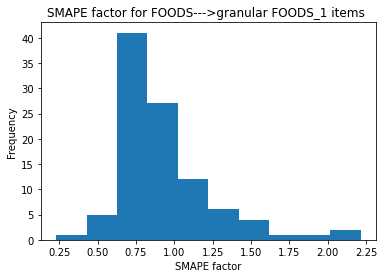

<IPython.core.display.Javascript object>

In [18]:
# Put the RMSE ratios in a list, so that we can plot in a histogram
ratio = []
for cat in list_of_FOODS_1_items:
    ratio.append(
        topdown_compare_ratio(
            column_to_filter="item_id",
            column_value_to_filter=cat,
            top_of_chain_sales=FOODS_sales,
            prediction_for_top_of_chain_sales=prediction_for_FOODS,
        )
    )

plt.title("SMAPE factor for FOODS--->granular FOODS_1 items ")
plt.xlabel("SMAPE factor")
plt.ylabel("Frequency")
plt.hist(ratio)

top_down_better = 0
for r in ratio:
    # if top down is better
    if r < 1:
        top_down_better += 1

print(f"Top down is better in {100*top_down_better/len(ratio)}% of the skus")
print("Sample size is: ", len(ratio))

### Comparing top-down method to direct Random Forest predictions for:

#### FOODS_1 ----> first 100 individual (granular) food items (Level 3 -----> Level 4)

For level 3 to level 4 in the product hierarchy, we find that the top-down approach is better 60-75% of the time for all items. This is the same as what we have found for level 2 to level 4. As an example, the results for the first 100 granular FOODS items are shown below in the histogram. 

In [19]:
# Re-define the top of the hierarchy as FOODS_1 rather than FOODS
FOODS1_sales, prediction_for_FOODS1 = top_of_hierarchy(
    column_to_filter="dept_id", column_value_to_filter="FOODS_1"
)

<IPython.core.display.Javascript object>

Top down is better in 74.0% of the skus
Sample size is:  100


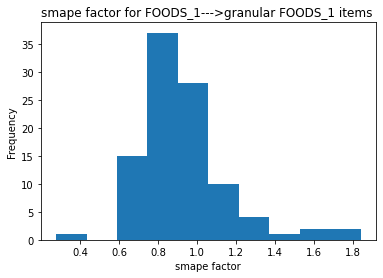

<IPython.core.display.Javascript object>

In [20]:
# Put the RMSE ratios in a list, so that we can plot in a histogram
ratio = []
for cat in list_of_FOODS_1_items:
    ratio.append(
        topdown_compare_ratio(
            column_to_filter="item_id",
            column_value_to_filter=cat,
            top_of_chain_sales=FOODS1_sales,
            prediction_for_top_of_chain_sales=prediction_for_FOODS1,
        )
    )

plt.title("smape factor for FOODS_1--->granular FOODS_1 items ")
plt.xlabel("smape factor")
plt.ylabel("Frequency")
plt.hist(ratio)

top_down_better = 0
for r in ratio:
    # if top down is better
    if r < 1:
        top_down_better += 1

print(f"Top down is better in {100*top_down_better/len(ratio)}% of the skus")
print("Sample size is: ", len(ratio))

### Comparing bottom-up method to direct Random Forest predictions for:
#### individual FOODS_1 items -----> FOODS_1   (Level 3 -----> Level 2)

For level 3 to level 2 of the hierarchy, we find that the bottom-up approach is better than direct modelling ~50% of the time. We show this for the FOODS category below. Note that the HOBBIES and HOUSEHOLD bottom up approaches were not as well-performing as the FOODS items (hence why it is better 50% of the time and not almost 100%, as seen with FOODS sub-categories below). 

In [21]:
# Predict level 3 directly for FOODS_1
FOODS_1_level_3_real, FOODS_1_level_3_predicted = level_3_prediction(
    items_sub_category="FOODS_1"
)

# Predict level 3 directly for FOODS_2
FOODS_2_level_3_real, FOODS_2_level_3_predicted = level_3_prediction(
    items_sub_category="FOODS_2"
)

# Predict level 3 directly for FOODS_3
FOODS_3_level_3_real, FOODS_3_level_3_predicted = level_3_prediction(
    items_sub_category="FOODS_3"
)

<IPython.core.display.Javascript object>

In [22]:
# Predict Level 2 directly for FOODS_1
FOODS_1_level_2_test, FOODS_1_level_2_predicted = level_2_prediction(
    items_sub_category="FOODS_1"
)

# Predict Level 2 directly for FOODS_2
FOODS_2_level_2_test, FOODS_2_level_2_predicted = level_2_prediction(
    items_sub_category="FOODS_2"
)

# Predict Level 2 directly for FOODS_3
FOODS_3_level_2_test, FOODS_3_level_2_predicted = level_2_prediction(
    items_sub_category="FOODS_3"
)

<IPython.core.display.Javascript object>



Average sales for items is:  3216.4416666666666


Root mean squared error is:  848.4127533223436
(Bottom Up) Root mean squared error is:  458.61817815404277
RMSE ratio between (Bottom Up)HTS:(Random Forest)TS =  0.5405602124179723


Symmetric mean absolute error (SMAPE) between real and direct forecast is:  20.117915125037054
Symmetric mean absolute error (SMAPE) between real and bottom up forecast is:  10.763379433146705
SMAPE ratio between (Bottom Up)HTS:(Random Forest)TS =  0.535014655656416


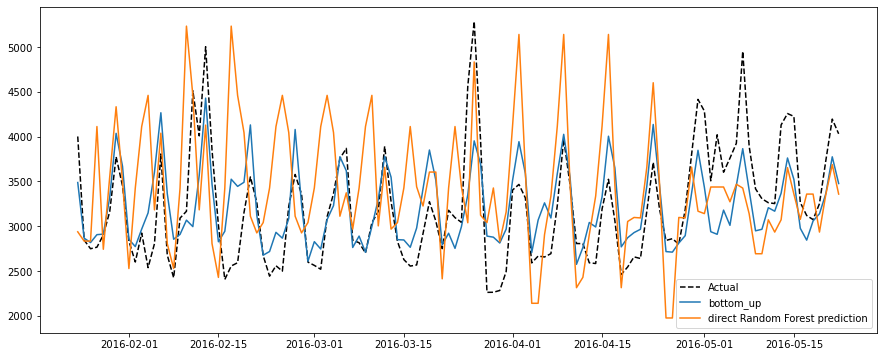

<IPython.core.display.Javascript object>

In [23]:
# Compare bottom-up with direct modelling of Level 2 for FOODS_1
cal_features.date = pd.to_datetime(cal_features.date)
compare_models(
    level_2_y_test=FOODS_1_level_2_test,
    level_2_y_predicted=FOODS_1_level_2_predicted,
    level_3_y_predicted=FOODS_1_level_3_predicted,
)



Average sales for items is:  5733.533333333334


Root mean squared error is:  1347.6429948865043
(Bottom Up) Root mean squared error is:  1139.3809832536263
RMSE ratio between (Bottom Up)HTS:(Random Forest)TS =  0.8454620308025884


Symmetric mean absolute error (SMAPE) between real and direct forecast is:  20.2955285064023
Symmetric mean absolute error (SMAPE) between real and bottom up forecast is:  16.00087297442298
SMAPE ratio between (Bottom Up)HTS:(Random Forest)TS =  0.788394003604067


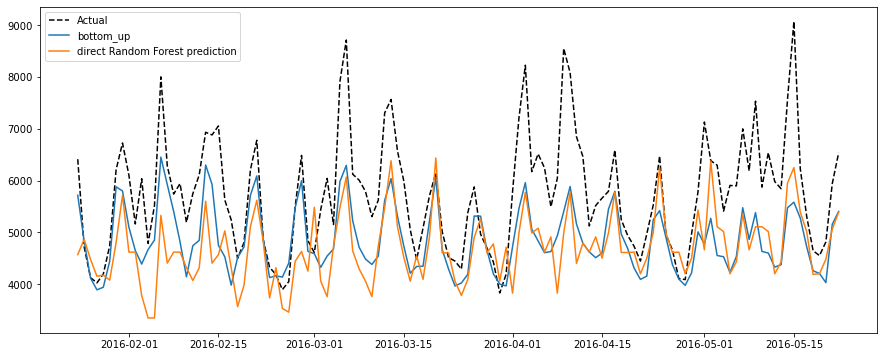

<IPython.core.display.Javascript object>

In [24]:
# Compare bottom-up with direct modelling of Level 2 for FOODS_2
compare_models(
    level_2_y_test=FOODS_2_level_2_test,
    level_2_y_predicted=FOODS_2_level_2_predicted,
    level_3_y_predicted=FOODS_2_level_3_predicted,
)



Average sales for items is:  19364.208333333332


Root mean squared error is:  2694.9073360692755
(Bottom Up) Root mean squared error is:  2612.2424163286732
RMSE ratio between (Bottom Up)HTS:(Random Forest)TS =  0.9693255056920899


Symmetric mean absolute error (SMAPE) between real and direct forecast is:  12.328183569205224
Symmetric mean absolute error (SMAPE) between real and bottom up forecast is:  11.817510924053865
SMAPE ratio between (Bottom Up)HTS:(Random Forest)TS =  0.958576813665642


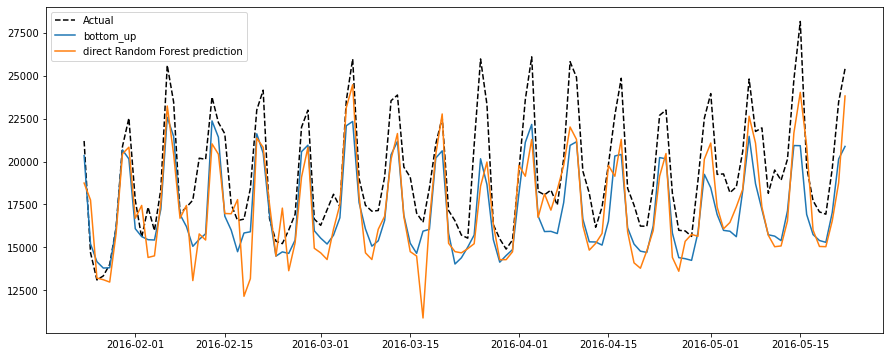

<IPython.core.display.Javascript object>

In [25]:
# Compare bottom-up with direct modelling of Level 2 for FOODS_2
compare_models(
    level_2_y_test=FOODS_3_level_2_test,
    level_2_y_predicted=FOODS_3_level_2_predicted,
    level_3_y_predicted=FOODS_3_level_3_predicted,
)